In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
ticker = 'BTC-USD'
start_date = "2025-05-04"
end_date = "2025-05-12"
try:
    btc_data = yf.download(ticker, start = start_date, end= end_date, interval='1m', progress=True)
    if btc_data.empty:
        print("Failed to download 1-minute data or no data returned.")
        raise ValueError("Empty DataFrame")
    print(f"Successfully downloaded {len(btc_data)} rows of 1-minute data.")
except Exception as e:
    print(f"Error fetching 1-minute data: {e}")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Successfully downloaded 9564 rows of 1-minute data.


In [4]:
btc_data

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-05-04 00:01:00+00:00,95853.492188,95853.492188,95853.492188,95853.492188,0
2025-05-04 00:02:00+00:00,95853.867188,95853.867188,95853.867188,95853.867188,0
2025-05-04 00:04:00+00:00,95905.195312,95905.195312,95905.195312,95905.195312,23522304
2025-05-04 00:06:00+00:00,95931.523438,95931.523438,95931.523438,95931.523438,0
2025-05-04 00:07:00+00:00,95936.195312,95936.195312,95936.195312,95936.195312,178358272
...,...,...,...,...,...
2025-05-11 23:54:00+00:00,104024.710938,104024.710938,104024.710938,104024.710938,21991424
2025-05-11 23:55:00+00:00,103987.265625,103987.265625,103987.265625,103987.265625,7372800


In [5]:

print("\nData Head:")
print(btc_data.head())
print("\nData Info:")
btc_data.info()
print("\nMissing Values:")
print(btc_data.isnull().sum())
btc_data.ffill(inplace=True) 
print("\nMissing Values after handling:")
print(btc_data.isnull().sum())



Data Head:
Price                             Close          High           Low  \
Ticker                          BTC-USD       BTC-USD       BTC-USD   
Datetime                                                              
2025-05-04 00:01:00+00:00  95853.492188  95853.492188  95853.492188   
2025-05-04 00:02:00+00:00  95853.867188  95853.867188  95853.867188   
2025-05-04 00:04:00+00:00  95905.195312  95905.195312  95905.195312   
2025-05-04 00:06:00+00:00  95931.523438  95931.523438  95931.523438   
2025-05-04 00:07:00+00:00  95936.195312  95936.195312  95936.195312   

Price                              Open     Volume  
Ticker                          BTC-USD    BTC-USD  
Datetime                                            
2025-05-04 00:01:00+00:00  95853.492188          0  
2025-05-04 00:02:00+00:00  95853.867188          0  
2025-05-04 00:04:00+00:00  95905.195312   23522304  
2025-05-04 00:06:00+00:00  95931.523438          0  
2025-05-04 00:07:00+00:00  95936.195312  1783582

<Figure size 1400x600 with 0 Axes>

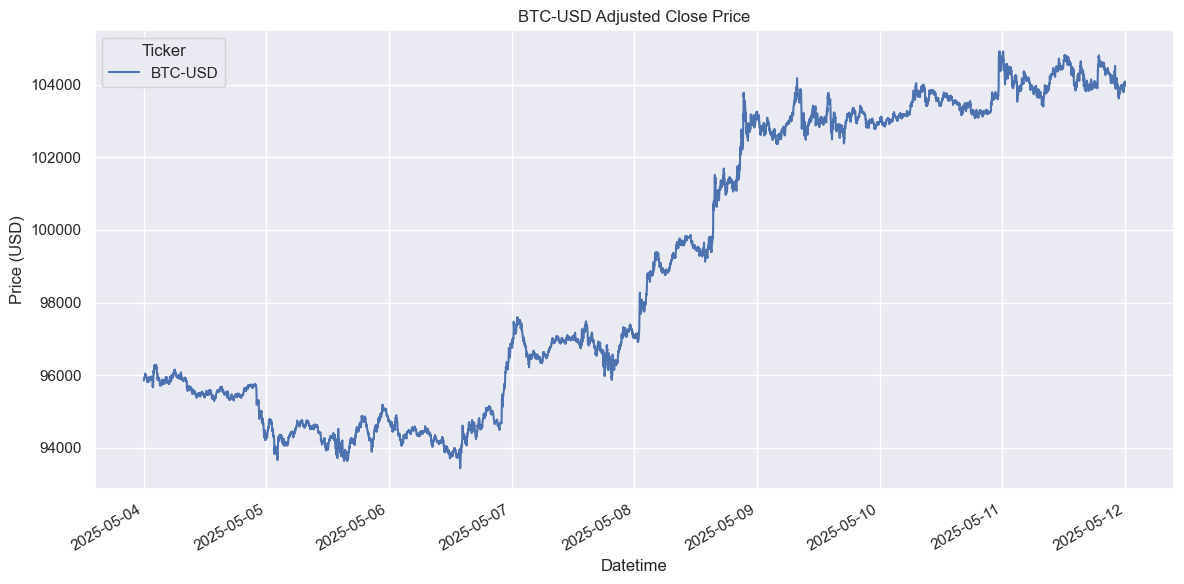

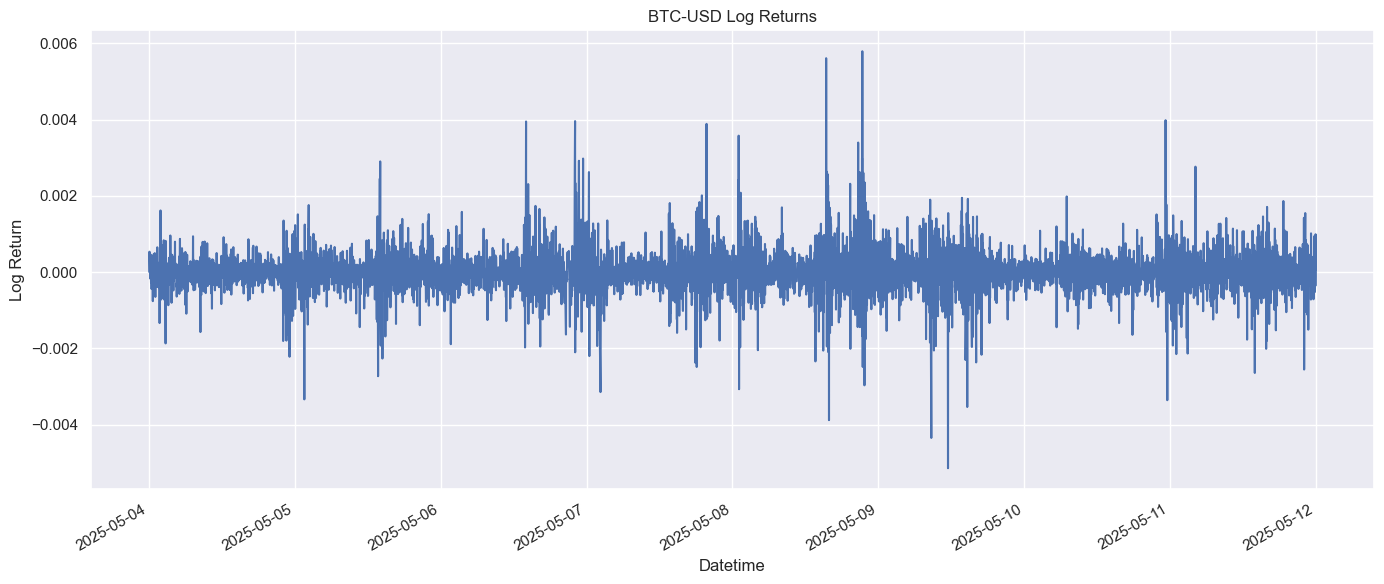


Log Returns Summary Statistics:
count    9563.000000
mean        0.000009
std         0.000480
min        -0.005139
25%        -0.000179
50%         0.000000
75%         0.000187
max         0.005788
Name: Log_Return, dtype: float64


In [6]:
import numpy as np
import matplotlib.pyplot as plt

btc_data['Log_Return'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))
btc_returns = btc_data['Log_Return'].dropna()

plt.figure(figsize=(14, 6))
btc_data['Close'].plot(title=f'{ticker} Adjusted Close Price')
plt.ylabel('Price (USD)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
btc_returns.plot(title=f'{ticker} Log Returns')
plt.ylabel('Log Return')
plt.tight_layout()
plt.show()

print("\nLog Returns Summary Statistics:")
print(btc_returns.describe())


In [7]:
adf_result = adfuller(btc_returns)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.4f}')

if adf_result[1] <= 0.05:
    print("\nResult: Reject the null hypothesis (H0). The log return series is likely stationary.")
else:
    print("\nResult: Fail to reject the null hypothesis (H0). The log return series is likely non-stationary.")

ADF Statistic: -18.1492
p-value: 0.0000
Critical Values:
	1%: -3.4310
	5%: -2.8618
	10%: -2.5669

Result: Reject the null hypothesis (H0). The log return series is likely stationary.


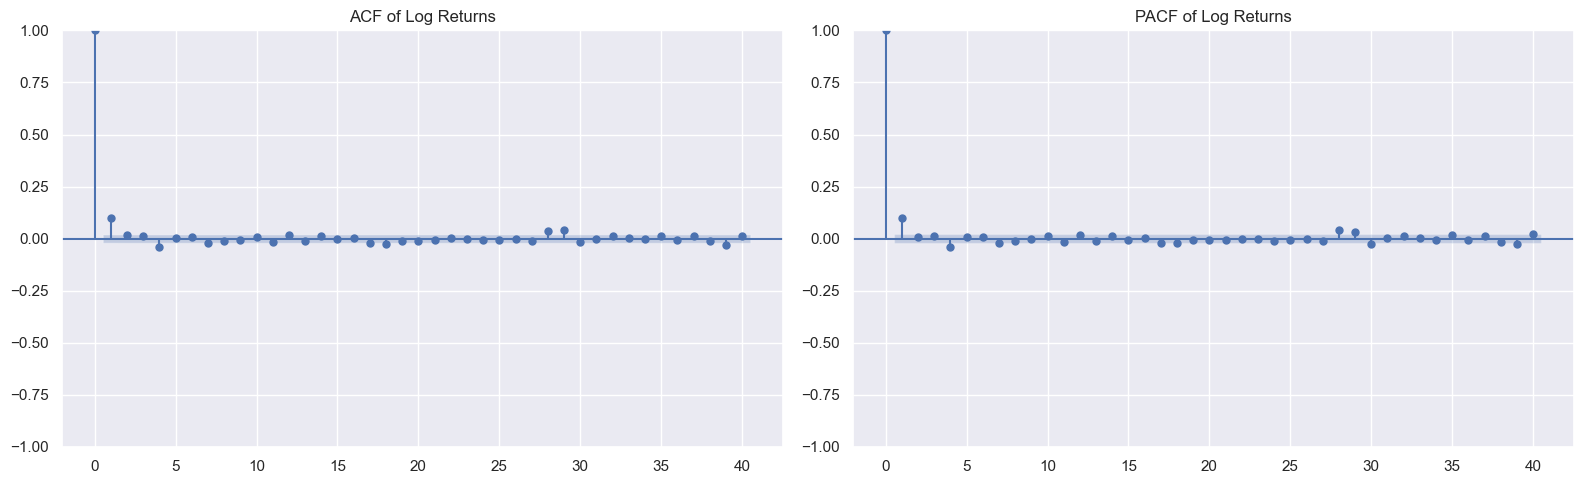

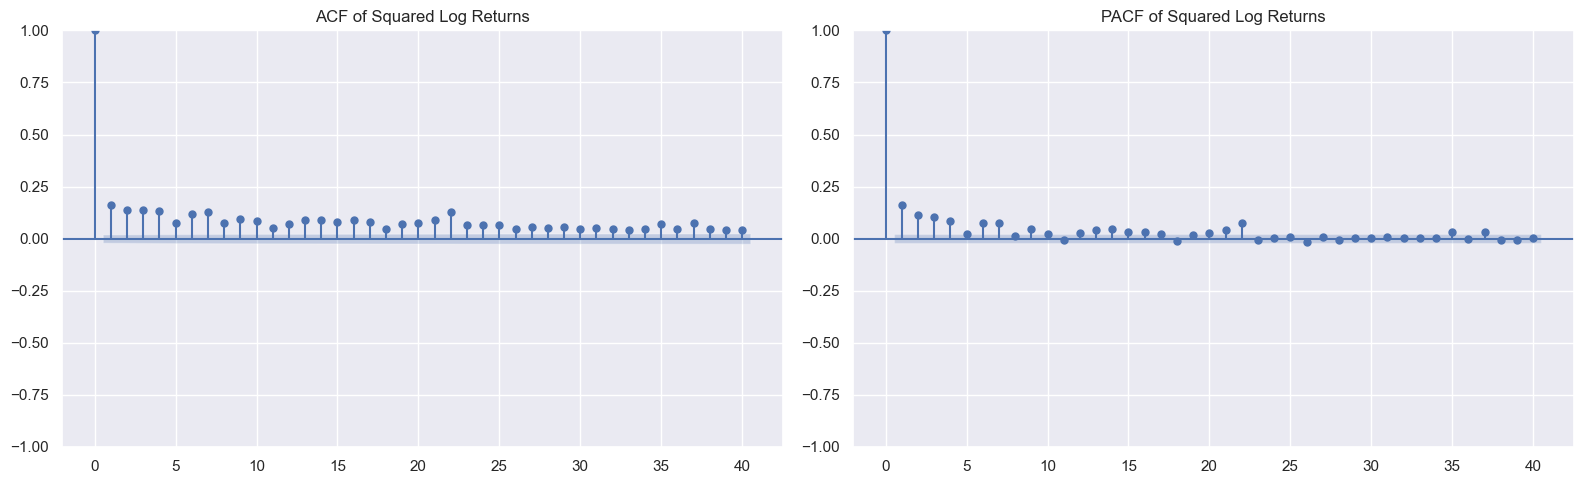

Ljung–Box test on squared returns (lag 10):
  statistic: 1335.7480
  p‑value:   0.0000
  Reject H₀: significant autocorrelation in squared returns (ARCH effects present).


<Figure size 800x600 with 0 Axes>

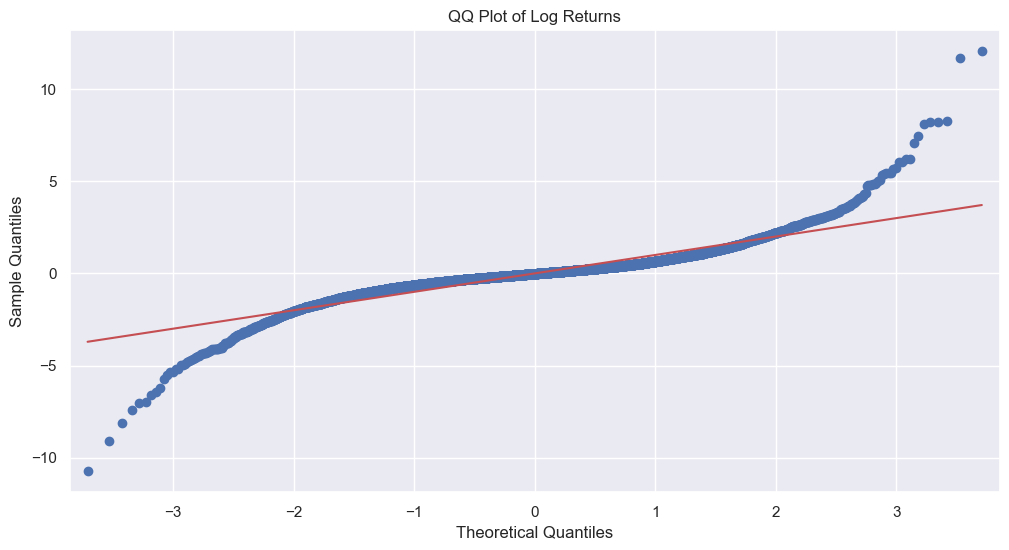

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(btc_returns, lags=40, ax=axes[0], title='ACF of Log Returns')
plot_pacf(btc_returns, lags=40, ax=axes[1], title='PACF of Log Returns')
plt.tight_layout()
plt.show()

squared_returns = btc_returns**2
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(squared_returns, lags=40, ax=axes[0], title='ACF of Squared Log Returns')
plot_pacf(squared_returns, lags=40, ax=axes[1], title='PACF of Squared Log Returns')
plt.tight_layout()
plt.show()

try:
    lb_res = acorr_ljungbox(squared_returns, lags=[10], return_df=True)
    lb_stat  = lb_res['lb_stat'].iloc[0]
    lb_pval  = lb_res['lb_pvalue'].iloc[0]

    print(f"Ljung–Box test on squared returns (lag 10):")
    print(f"  statistic: {lb_stat:.4f}")
    print(f"  p‑value:   {lb_pval:.4f}")

    if lb_pval <= 0.05:
        print("  Reject H₀: significant autocorrelation in squared returns (ARCH effects present).")
    else:
        print("  Fail to reject H₀: no evidence of ARCH effects.")

except Exception as e:
    print(f"An error occurred during the Ljung-Box test on squared returns: {e}")


plt.figure(figsize=(8, 6))
qqplot(btc_returns, line='s', fit=True)
plt.title('QQ Plot of Log Returns')
plt.show()

In [9]:
print("\n--- Fitting E-GARCH(1,1) Model ---")
# Winsorized returns to reduce the influence of extreme values
btc_returns = btc_returns.clip(lower=-0.1, upper=0.1) 
egarch_model = arch_model(btc_returns * 100, 
                            vol='EGARCH',
                            p=1, o=1, q=1,       
                            dist='normal')       

egarch_result = egarch_model.fit(disp='off', last_obs=None)
print(egarch_result.summary())

aic = egarch_result.aic
bic = egarch_result.bic
print(f"\nModel Evaluation Metrics:")
print(f"  Akaike Information Criterion (AIC): {aic:.4f}")
print(f"  Bayesian Information Criterion (BIC): {bic:.4f}")




--- Fitting E-GARCH(1,1) Model ---
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                17209.6
Distribution:                  Normal   AIC:                          -34409.1
Method:            Maximum Likelihood   BIC:                          -34373.3
                                        No. Observations:                 9563
Date:                Fri, May 16 2025   Df Residuals:                     9562
Time:                        01:08:21   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.4340e-

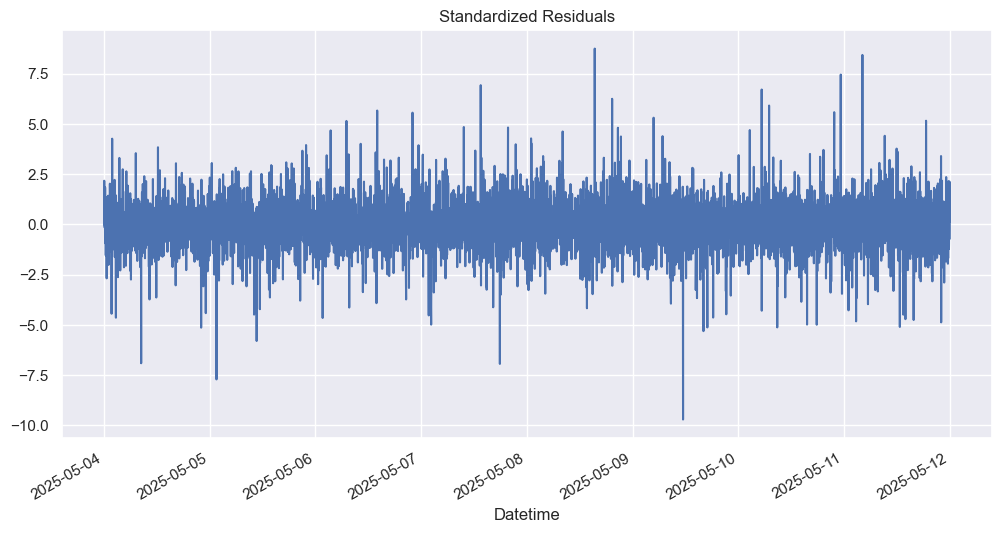

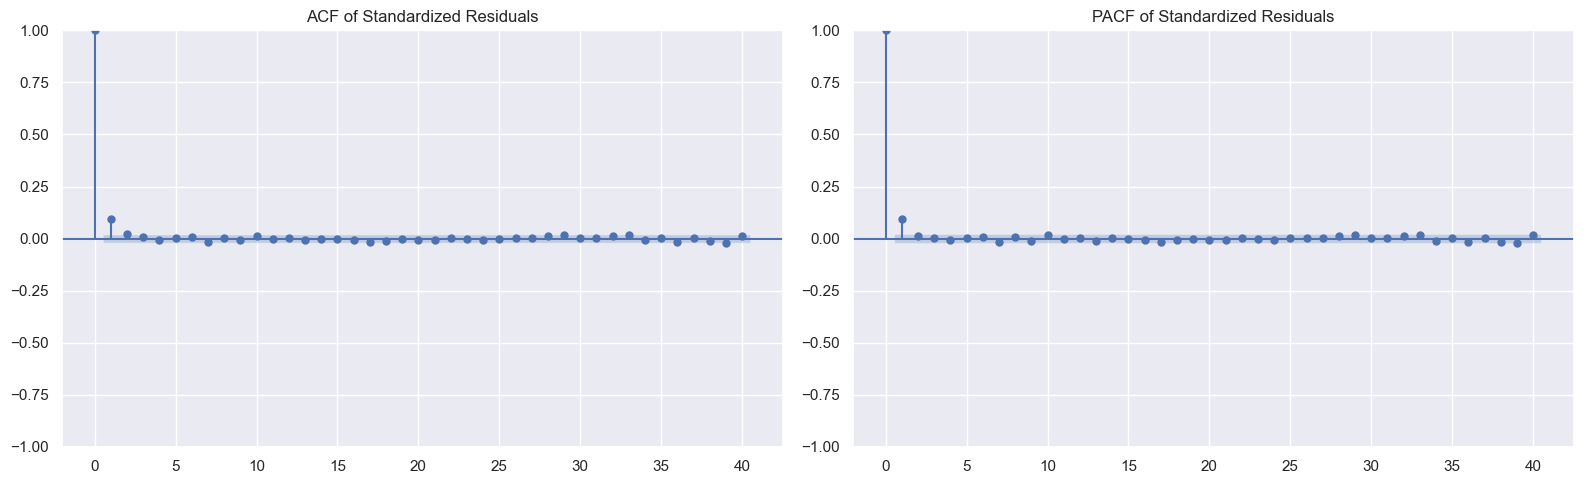

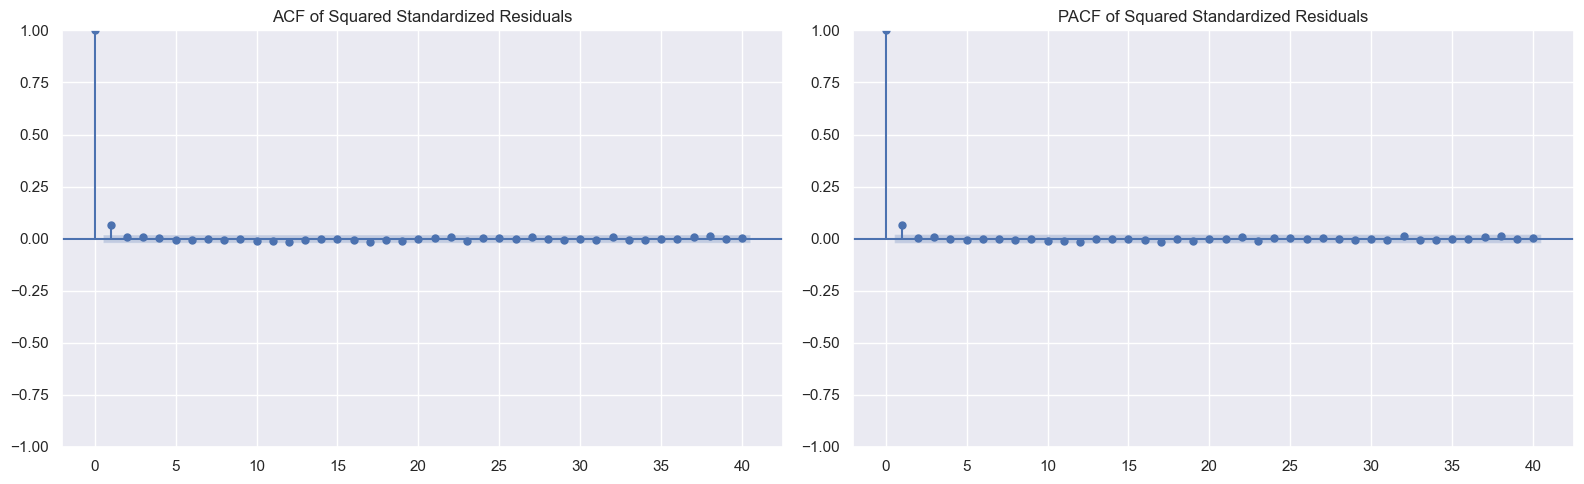

<Figure size 800x600 with 0 Axes>

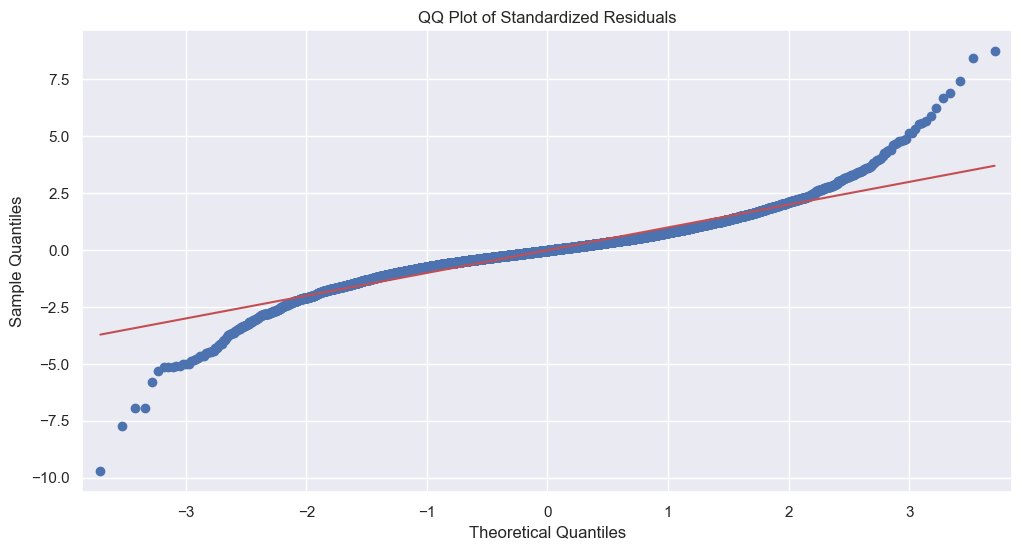

In [10]:
std_resid = egarch_result.resid / egarch_result.conditional_volatility

plt.figure(figsize=(12, 6))
std_resid.plot(title='Standardized Residuals')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(std_resid, lags=40, ax=axes[0], title='ACF of Standardized Residuals')
plot_pacf(std_resid, lags=40, ax=axes[1], title='PACF of Standardized Residuals')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(std_resid**2, lags=40, ax=axes[0], title='ACF of Squared Standardized Residuals')
plot_pacf(std_resid**2, lags=40, ax=axes[1], title='PACF of Squared Standardized Residuals')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
qqplot(std_resid, line='s', fit=True) 
plt.title('QQ Plot of Standardized Residuals')
plt.show()


                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:                18291.4
Distribution:      Standardized Student's t   AIC:                          -36562.9
Method:                  Maximum Likelihood   BIC:                          -36491.2
                                              No. Observations:                 9563
Date:                      Fri, May 16 2025   Df Residuals:                     9562
Time:                              01:08:23   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

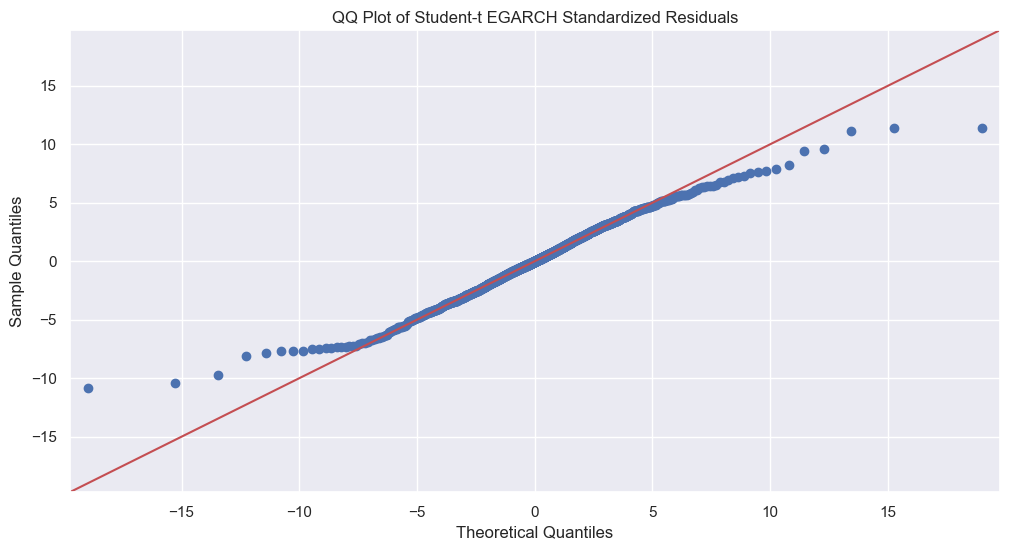

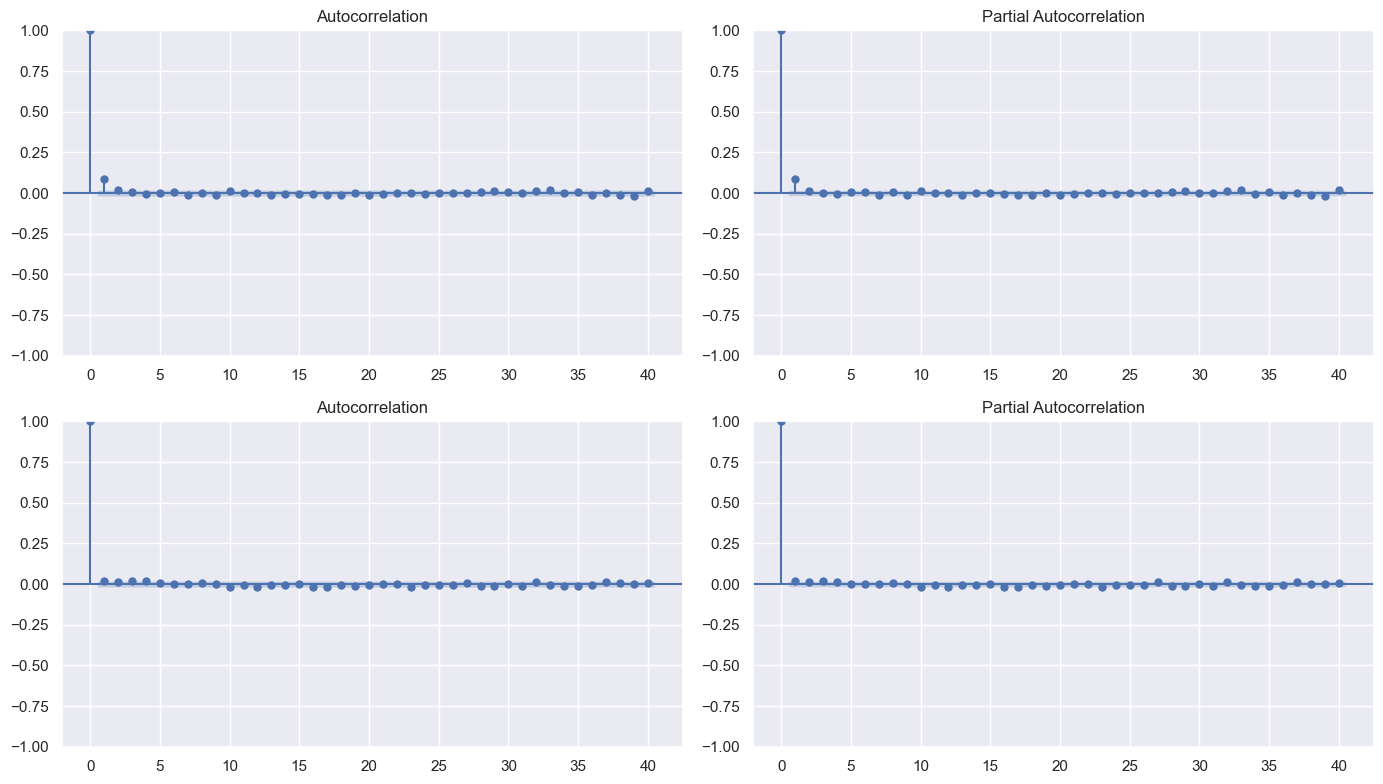

      lb_stat  lb_pvalue
10  14.292463   0.160065
1913 1913
Kupiec statistic: 12.4368
Kupiec p-value: 0.0004


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

lower, upper = np.nanpercentile(btc_returns, [0.2, 99.8])
r = btc_returns.clip(lower, upper)

m0 = arch_model(r*100, vol='EGARCH', p=2, o=3, q=2, dist='normal')
res0 = m0.fit(update_freq=0, disp='off')

start = pd.concat([res0.params, pd.Series({'nu': 10.0})])

m = arch_model(r*100, vol='EGARCH', p=2, o=3, q=2, dist='t')
res = m.fit(
    update_freq=0,
    disp='off',
    starting_values=start,
    tol=1e-6,
    options={'maxiter': 1000}
)

print(res.summary())

std_resid = res.std_resid
nu = res.params['nu']
qqplot(std_resid,
       dist=stats.t,
       distargs=(nu,),
       fit=True,
       line='45')
plt.title('QQ Plot of Student-t EGARCH Standardized Residuals')
plt.show()

fig, ax = plt.subplots(2,2,figsize=(14,8))
plot_acf(std_resid, lags=40, ax=ax[0,0])
plot_pacf(std_resid, lags=40, ax=ax[0,1])
plot_acf(std_resid**2, lags=40, ax=ax[1,0])
plot_pacf(std_resid**2, lags=40, ax=ax[1,1])
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(std_resid**2, lags=[10], return_df=True)
print(lb)

lower, upper = np.nanpercentile(btc_returns, [0.2, 99.8])
r = btc_returns.clip(lower, upper).dropna()

m0 = arch_model(r*100, vol='EGARCH', p=2, o=3, q=2, dist='normal')
res0 = m0.fit(update_freq=0, disp='off')
start_params = res0.params.copy()
start_params['nu'] = 10.0

m = arch_model(r*100, vol='EGARCH', p=2, o=3, q=2, dist='t')
res = m.fit(update_freq=0, disp='off', starting_values=start_params, tol=1e-6, options={'maxiter': 1000})

split = int(0.8 * len(r))
train_end = r.index[split-1]
model = arch_model(r*100, vol='EGARCH', p=2, o=3, q=2, dist='t')
fitted = model.fit(last_obs=train_end, update_freq=0, disp='off', starting_values=start_params)

fcast = fitted.forecast(horizon=1, align='target')
sigma2 = fcast.variance['h.1'].loc[r.index[split:]].values

nu = fitted.params['nu']
var99 = np.sqrt(sigma2)/100 * stats.t.ppf(0.01, df=nu)
var_series = pd.Series(var99, index=r.index[split:])

test = r.iloc[split:]
violations = (test < var_series).astype(int)
n, x = len(violations), violations.sum()
alpha = 0.01
p_hat = max(x/n, 1e-10)
kupiec_stat = -2*((x*np.log(alpha)+(n-x)*np.log(1-alpha)) - (x*np.log(p_hat)+(n-x)*np.log(1-p_hat)))
kupiec_p = stats.chi2.sf(kupiec_stat, 1)
print(len(sigma2), len(test))
print(f'Kupiec statistic: {kupiec_stat:.4f}')
print(f'Kupiec p-value: {kupiec_p:.4f}')



In [13]:
pred_var_egarch = sigma2 / 10000.0
actual_sq_egarch = (r.iloc[split:] ** 2).values
rmse_egarch = np.sqrt(np.mean((pred_var_egarch - actual_sq_egarch) ** 2))
print(f"EGARCH RMSE:      {rmse_egarch:.6e}")

EGARCH RMSE:      5.015599e-07


In [ ]:
t_alpha    = stats.t.ppf(alpha, df=nu)
pdf_t      = stats.t.pdf(t_alpha, df=nu)
es_factor_t= pdf_t * (nu + t_alpha**2) / ((nu - 1) * alpha)
es_series  = np.sqrt(sigma2) / 100 * es_factor_t
print(f'Average ES at {alpha*100:.1f}% level: {es_series.mean():.6f}')


Average ES at 1.0% level: 0.002830


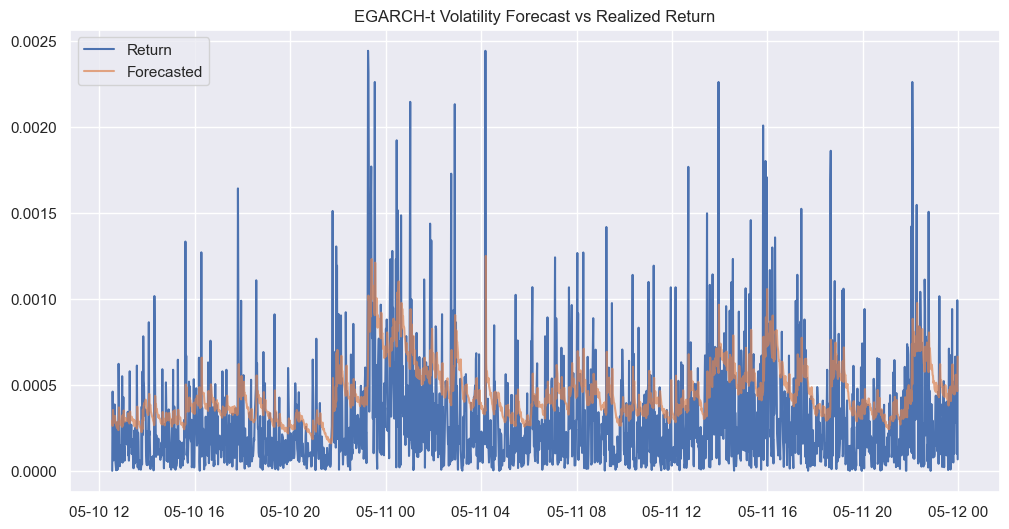

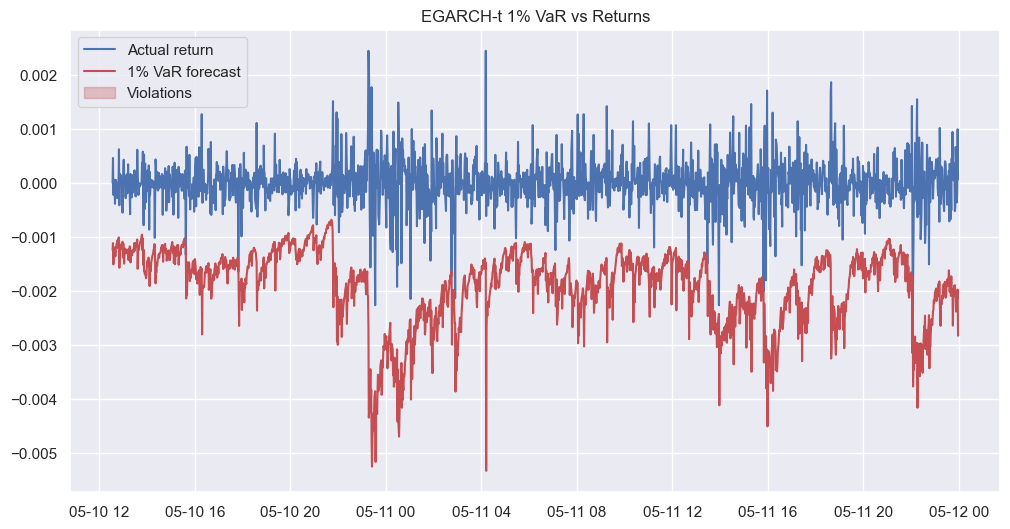

In [ ]:
import matplotlib.pyplot as plt


vol_forecast = np.sqrt(sigma2) / 100       
realized_abs = np.abs(test.values)       

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(test.index, realized_abs,    label='Return', alpha=1)
ax.plot(test.index, vol_forecast,    label='Forecasted', alpha = 0.7)
ax.set_title('EGARCH-t Volatility Forecast vs Realized Return')
ax.legend()
plt.show()


fig, ax = plt.subplots(figsize=(12,6))
ax.plot(test.index, test.values,            label='Actual return')
ax.plot(var_series.index, var_series,      label='1% VaR forecast', color='C3')
ax.fill_between(var_series.index,
                test.values,
                var_series,
                where=(test.values < var_series),
                color='C3', alpha=0.3,
                label='Violations')
ax.set_title('EGARCH-t 1% VaR vs Returns')
ax.legend()
plt.show()
